# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.simplefilter("ignore")

# Data Preprocessing

## Loading Dataset

In [2]:
data = pd.read_csv("Language Detection.csv")

In [3]:
data.head()

,Text,Language
0,"Nature, in the broadest sense, is the natural...",English
1,"""Nature"" can refer to the phenomena of the phy...",English
2,"The study of nature is a large, if not the onl...",English
3,"Although humans are part of nature, human acti...",English
4,[1] The word nature is borrowed from the Old F...,English


## Handling missing values

In [4]:
data.isnull().sum()

Text        0
Language    0
dtype: int64

## Visualizing the distribution of languages

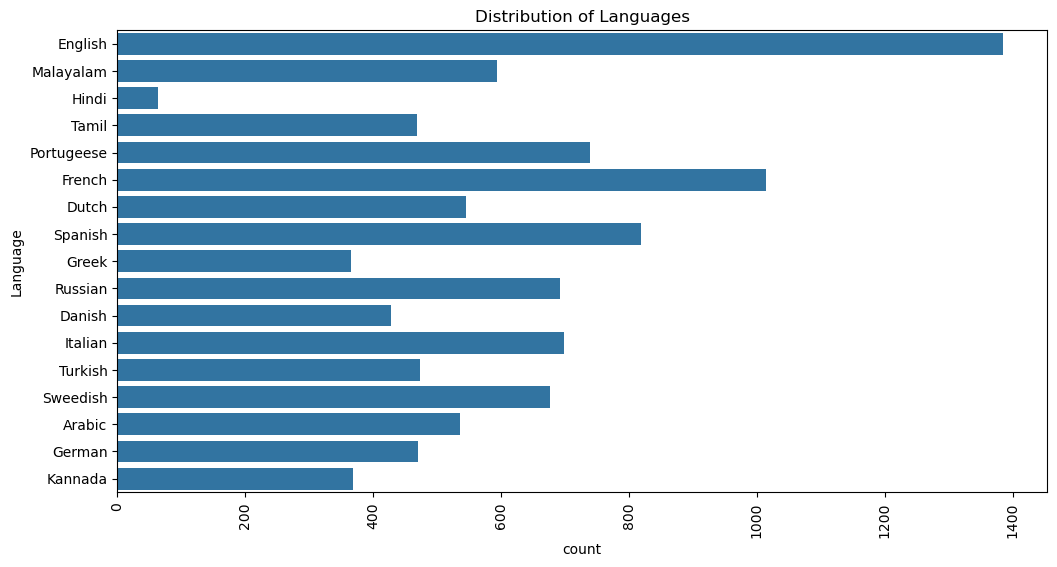

In [21]:
plt.figure(figsize=(12, 6))
sns.countplot(data['Language'])
plt.title('Distribution of Languages')
plt.xticks(rotation=90)
plt.show()

## Extracting Features & Labels

In [7]:
X = data["Text"]
y = data["Language"]

## Encoding Labels

In [8]:
le = LabelEncoder()
y = le.fit_transform(y)

## Data cleaning

In [9]:
def clean_text(text):
    text = re.sub(r'[!@#$(),\n"%^*?\:;~`0-9]', ' ', text)
    text = re.sub(r'[[]]', ' ', text)
    text = text.lower()
    return text

X = X.apply(clean_text)

# Feature Engineering

## Train test split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

## TF-IDF vectorizer

In [11]:
tfidf = TfidfVectorizer(ngram_range=(1, 2))
tfidf.fit(X_train)

x_train = tfidf.transform(X_train).toarray()
x_test  = tfidf.transform(X_test).toarray()

# Model selection and Hyperparameter tuning

## Mulitnomial Naive Bayes with hyperparameter tuning

In [12]:
model = MultinomialNB()
params = {'alpha': [0.01, 0.1, 0.5, 1]}
grid_search = GridSearchCV(model, param_grid=params, cv=5, scoring='accuracy')
grid_search.fit(x_train, y_train)

best_model = grid_search.best_estimator_

# Visualization

## Plotting accuracy over different alpha values

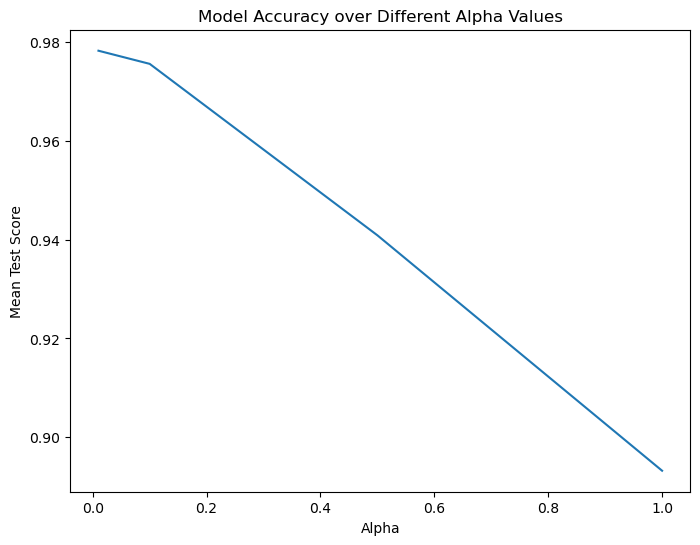

In [13]:
# Plot accuracy over different alpha values
results = pd.DataFrame(grid_search.cv_results_)
plt.figure(figsize=(8, 6))
sns.lineplot(x='param_alpha', y='mean_test_score', data=results)
plt.title('Model Accuracy over Different Alpha Values')
plt.xlabel('Alpha')
plt.ylabel('Mean Test Score')
plt.show()

# Model validation

## Making predictions and evaluating the model

In [22]:
y_pred = best_model.predict(x_test)

ac = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred)

print("Accuracy is :", ac)
print("Classification Report:\n", cr)

Accuracy is : 0.9787234042553191
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99        96
           1       0.98      0.99      0.98        89
           2       0.99      0.97      0.98       115
           3       0.89      0.99      0.94       289
           4       0.99      0.99      0.99       196
           5       1.00      0.97      0.98        96
           6       1.00      0.99      0.99        70
           7       1.00      1.00      1.00        15
           8       1.00      0.99      1.00       137
           9       1.00      0.98      0.99        84
          10       1.00      0.98      0.99       118
          11       1.00      0.99      1.00       141
          12       1.00      0.96      0.98       141
          13       0.98      0.97      0.97       155
          14       0.99      0.96      0.98       143
          15       1.00      0.98      0.99        93
          16       1.00 

## Visualizing the confusion matrix

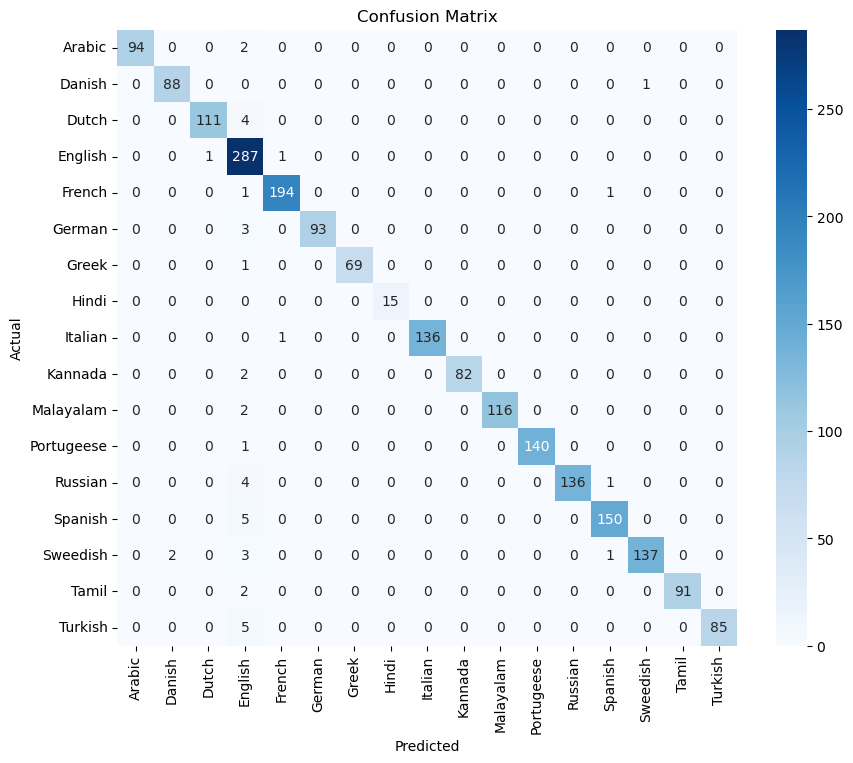

In [15]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Model Deployment

## Creating and saving the pipeline

In [16]:
pipe = Pipeline([('vectorizer', tfidf), ('multinomialNB', best_model)])
pipe.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer(ngram_range=(1, 2))),
                ('multinomialNB', MultinomialNB(alpha=0.01))])

## Pickle file creation

In [17]:
with open('trained_pipeline-0.1.0.pkl', 'wb') as f:
    pickle.dump(pipe, f)

# Making Predictions

In [18]:
text = "Hello, how are you?"
y = pipe.predict([text])
print(le.classes_[y[0]], y)

English [3]


In [19]:
text = "Ciao, come stai?"
y = pipe.predict([text])
print(le.classes_[y[0]], y)

Italian [8]


In [20]:
text = "Bonjour, comment vas-tu ?"
y = pipe.predict([text])
print(le.classes_[y[0]], y)

French [4]
